# ENSEMBLE OF FORECASTERS
__Authors__
- Luca Guffanti
- Giorgio Daneri
- Daniele Ferrario

## MPI Parallelization
The MPI parallelization focuses on the even distribution of the workload among the available processes. The main idea is to deploy a predefined number 
of forecasters on each process, letting them work independently on the available data through the training and inference phases. Final predictions are then aggregated with the learnt weights and biases, and a statistical analysis is performed to evaluate the performance of the ensemble.

The engineered solution consists in a wrapper class, `MPIDistributionStrategy`, that is responsible for the distribution of the workload and the orchestration of the parallel agents. When constructed, `MPIDistributionStrategy` requires passing a type of forecaster to be used, which must be
a type name that inherits from the abstract `ForecasterBase` object, implementing methods for training and inference, and exposing a gradient computation function. Thus, the original ARNN forecaster proposed in `seq.py` has been turned into and object, and is the implementation on which the native MPI approach was tested on.

The following results for the MPI implementation are obtained by distributing $1.28\times10^6$ forcasters among 128 processes.

## Analysis of the weights
A generic weight $w_{ij}$ describes the contribution of the $j$-th window variable on the $i$-th feature.  

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('preds/weights.csv')
df.describe()

,forecaster,w00,w01,w02,w03,w04,w05,w10,w11,w12,w13,w14,w15
count,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06
mean,6.399995e+05,-7.927275e-02,6.830836e-01,-7.913251e-02,6.040954e-01,-7.916396e-02,5.246227e-01,-6.608978e-03,9.741039e-01,-6.563784e-03,9.673992e-01,-6.575097e-03,9.609588e-01
std,3.695043e+05,9.965164e-02,9.337186e-02,9.963899e-02,8.936603e-02,9.971688e-02,8.431455e-02,9.968791e-02,9.342803e-02,9.968545e-02,8.951347e-02,9.966550e-02,8.428748e-02
min,0.000000e+00,-5.848534e-01,1.885886e-01,-5.436674e-01,1.555848e-01,-5.464737e-01,9.330984e-02,-5.087182e-01,5.486020e-01,-4.912561e-01,5.261370e-01,-5.446552e-01,5.707091e-01
25%,3.199998e+05,-1.465395e-01,6.200188e-01,-1.461837e-01,5.438220e-01,-1.463637e-01,4.678292e-01,-7.379582e-02,9.111114e-01,-7.392436e-02,9.069349e-01,-7.381169e-02,9.040606e-01
50%,6.399995e+05,-7.918549e-02,6.830992e-01,-7.913280e-02,6.040825e-01,-7.916715e-02,5.246427e-01,-6.441444e-03,9.741029e-01,-6.542966e-03,9.674695e-01,-6.641160e-03,9.609514e-01
75%,9.599992e+05,-1.202637e-02,7.460436e-01,-1.183279e-02,6.643008e-01,-1.198291e-02,5.815877e-01,6.066658e-02,1.036954e+00,6.075709e-02,1.027787e+00,6.065826e-02,1.017733e+00
max,1.279999e+06,4.056686e-01,1.095754e+00,3.948286e-01,1.034322e+00,4.166578e-01,9.360126e-01,5.127912e-01,1.437207e+00,4.899625e-01,1.434918e+00,4.546717e-01,1.346593e+00


Text(0.5, 0.98, 'Weights distribution')

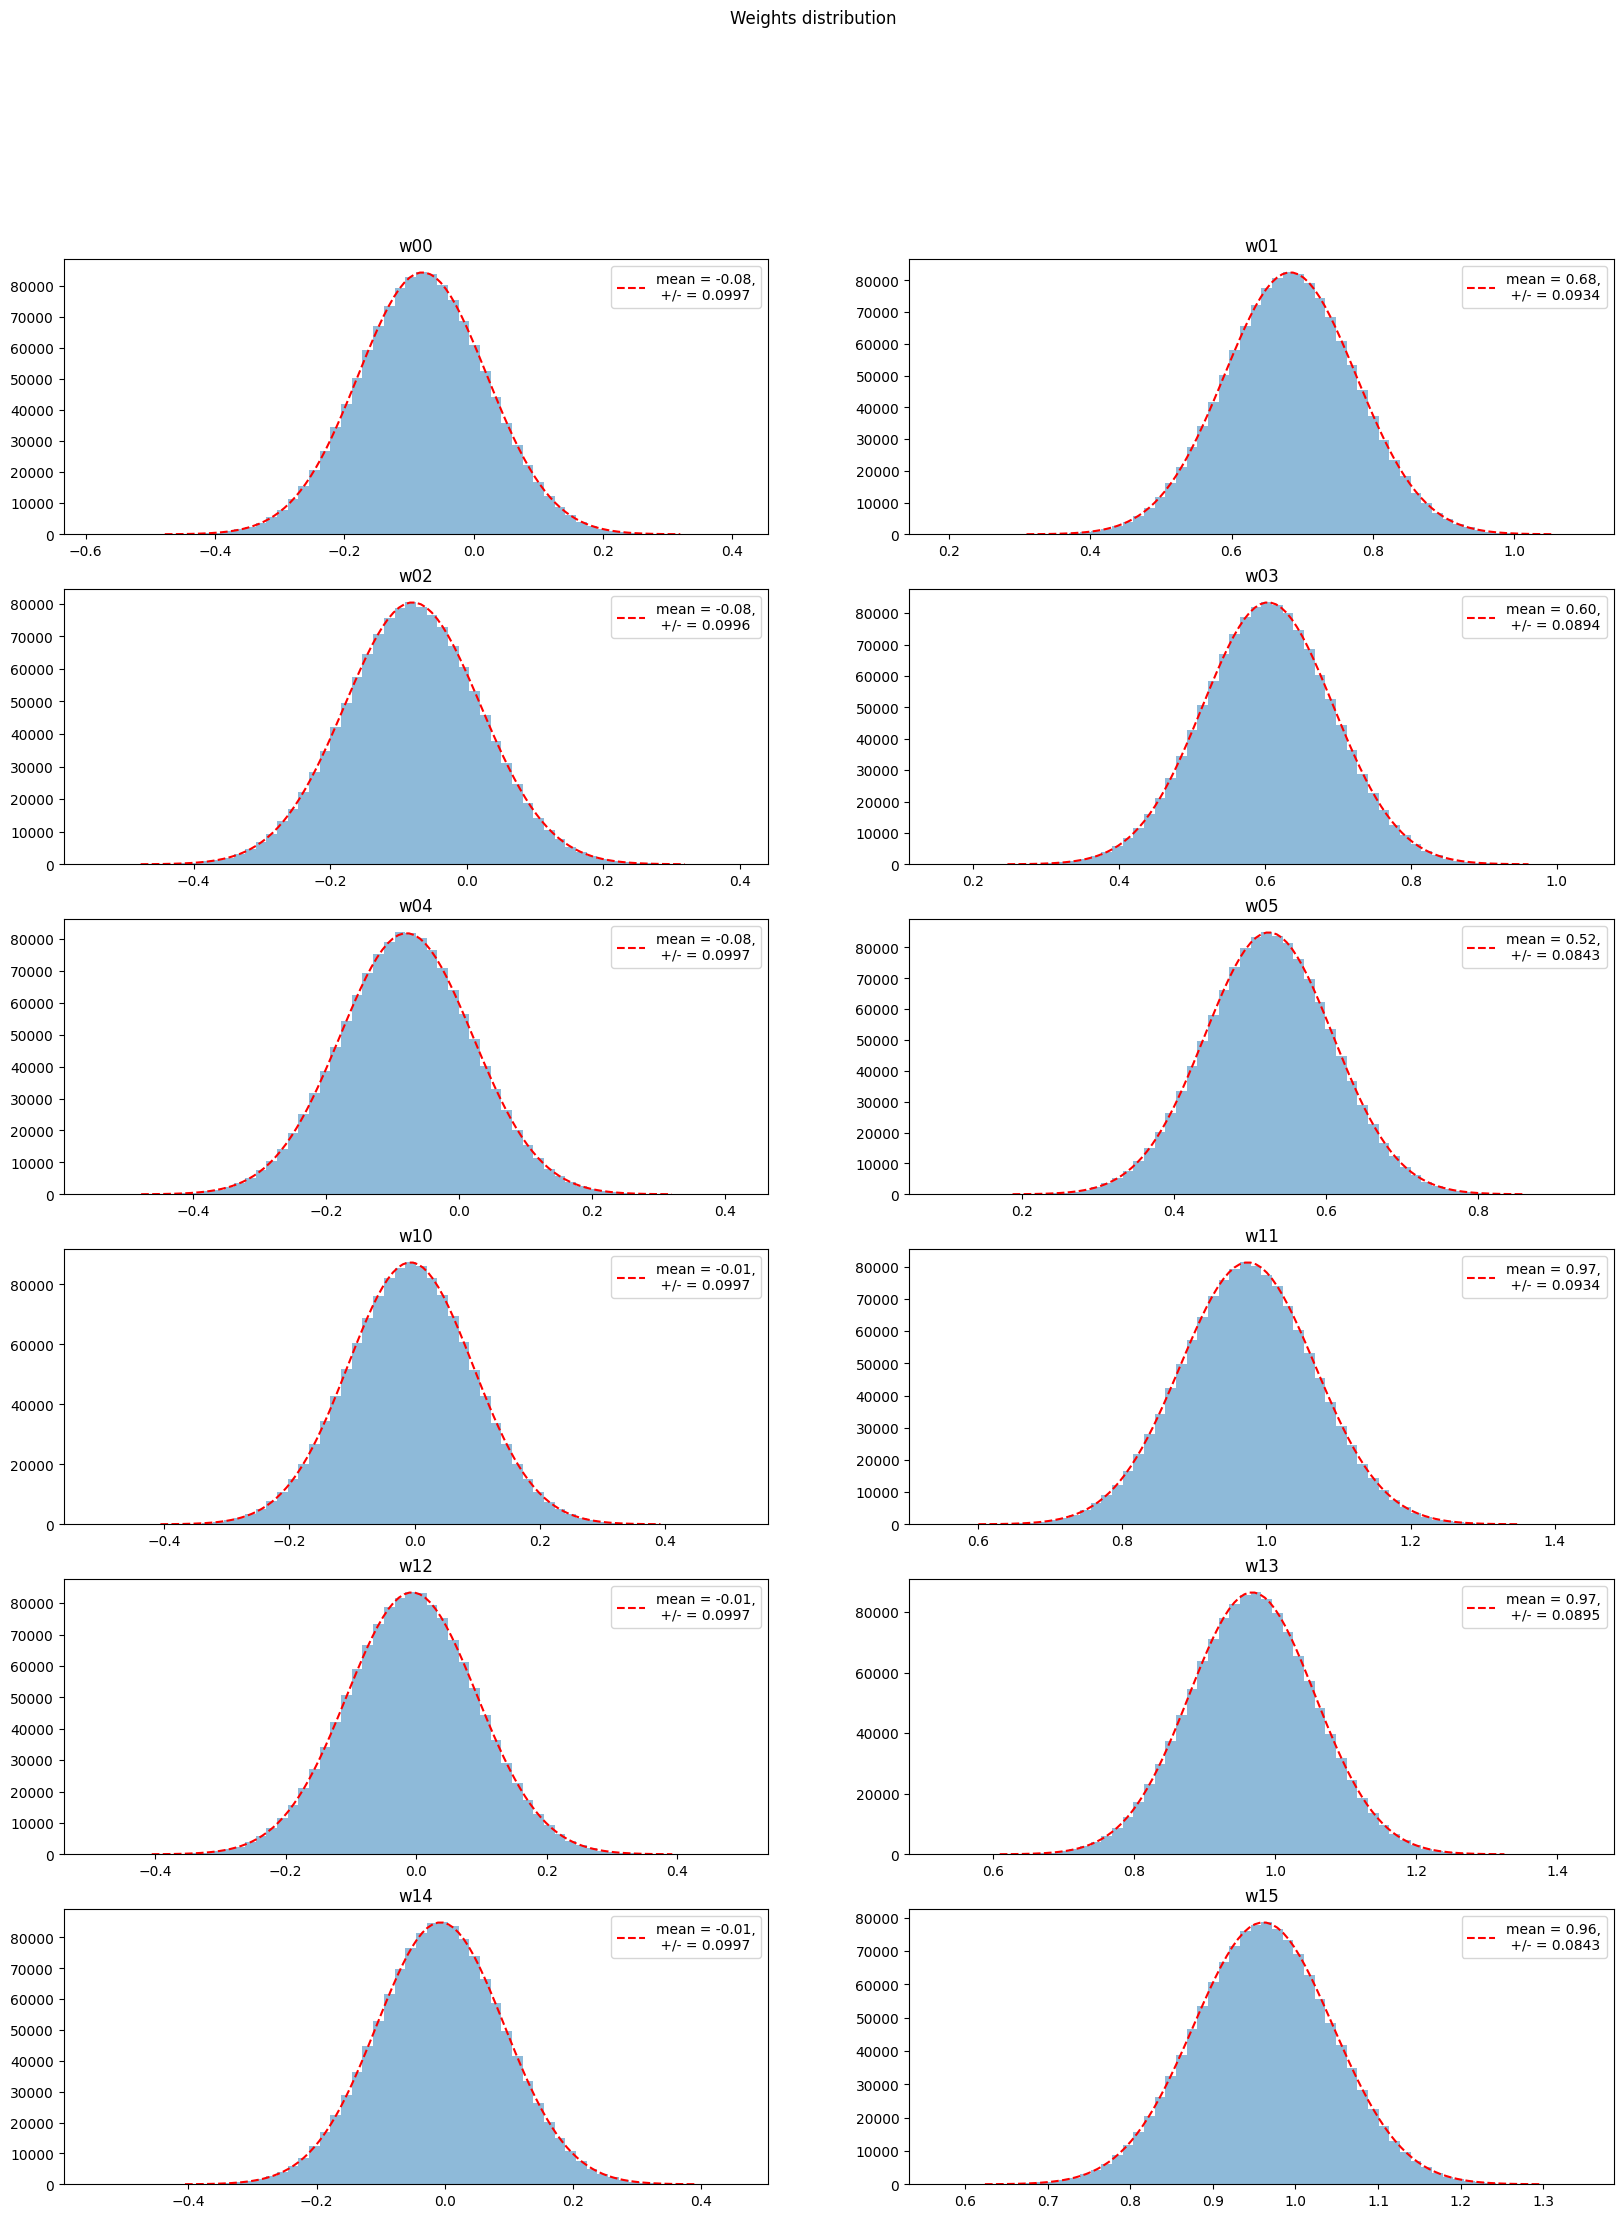

In [11]:


# Create a figure with 12 subplots
fig, axs = plt.subplots(6, 2, figsize=(20, 25))  

# On the i-th axis, plot the i-th column of the data
for i, ax in enumerate(axs.flat):
    hist_values, bin_edges, _ = ax.hist(df.iloc[:, i+1], bins=60, alpha=0.5)
    
    # Superimpose a gaussian distribution with the same mean and standard deviation
    mean = df.iloc[:, i+1].mean()
    std = df.iloc[:, i+1].std()
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
    # Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
    
    bin_width = bin_edges[1] - bin_edges[0]
    mean_bin_index = np.digitize(mean, bin_edges) - 1  # Get the bin containing the mean
    mean_bin_height = hist_values[mean_bin_index]

    y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
    
    ax.plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std), )
    ax.legend(loc='upper right')
    ax.set_title(df.columns[i+1])

# give the title to the entire figure
fig.suptitle('Weights distribution')

As it can be seen, weights adopt an (almost standardized) Gaussian distribution.

## Analysis of the biases
All biases are aggregated in a single plot, which is shown below

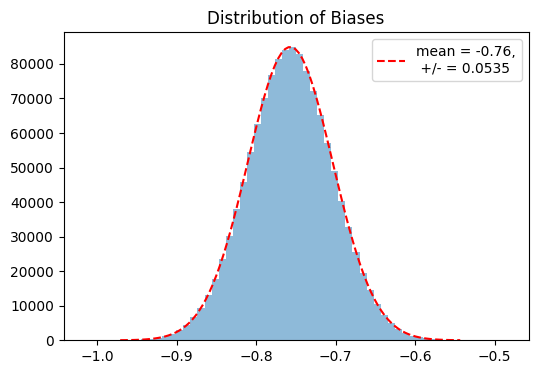

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('preds/biases.csv')
# Create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# Plot the data
hist_values, bin_edges, _ = ax.hist(df.iloc[:, 1], bins=60, alpha=0.5)
ax.set_title("Distribution of Biases")
# Superimpose a gaussian distribution with the same mean and standard deviation
mean = df.iloc[:, 1].mean()
std = df.iloc[:, 1].std()
x = np.linspace(mean - 4*std, mean + 4*std, 100)
y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
# Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
bin_width = bin_edges[1] - bin_edges[0]
mean_bin_index = np.digitize(mean, bin_edges) - 1  # Get the bin containing the mean
mean_bin_height = hist_values[mean_bin_index]
y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
ax.plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std))
ax.legend(loc='upper right')


plt.show()

Again, we can observe a Gaussian distribution.

## Analysis of the predictions

Plots for prediction are shown below and are grouped horizontally by features and vertically by prediction step. 

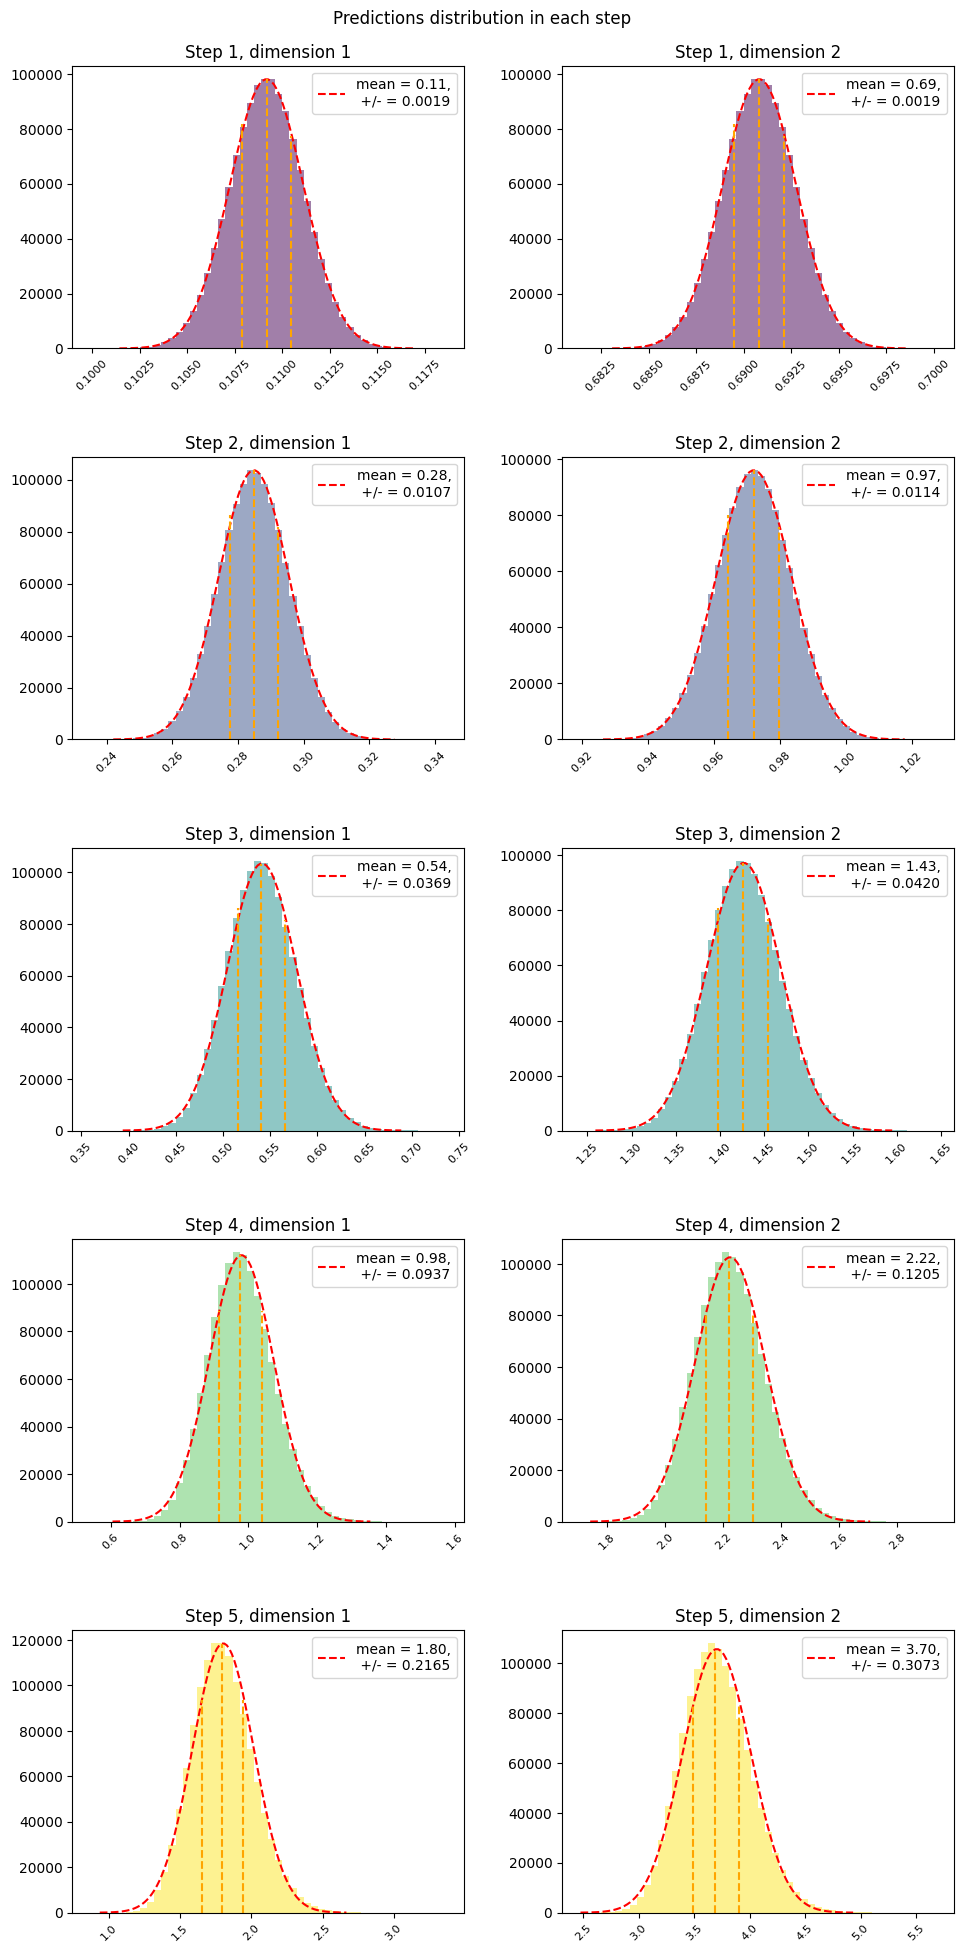

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('preds/predictions.csv')
# Create a figure with a number of subplots equal to the maximum of the first column
fig, axs = plt.subplots(df.iloc[:, 0].max()+1, 2, figsize=(10, 20))

# define a colormap with a number of colors equal to the maximum in the first column
colors = plt.cm.viridis(np.linspace(0, 1, df.iloc[:, 0].max()+1))

# Plot the data
for i in range(0, df.iloc[:, 0].max()+1):
    for j in range(2):
        hist_values, bin_edges, _ = axs[i, j].hist(df[df.iloc[:, 0] == i].iloc[:, j+1], bins=50, color=colors[i], alpha=0.5,)
        axs[i, j].set_title(f"Step {i+1}, dimension {j+1}")
        # Set the labels of the x-axis to a small font with rotation
        axs[i, j].tick_params(axis='x', labelsize=8, rotation=45)

        # Superimpose a gaussian distribution with the same mean and standard deviation
        mean = df[df.iloc[:, 0] == i].iloc[:, j+1].mean()
        std = df[df.iloc[:, 0] == i].iloc[:, j+1].std()
        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
        # Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
        bin_width = bin_edges[1] - bin_edges[0]
        mean_bin_index = np.digitize(mean, bin_edges) - 1
        mean_bin_height = hist_values[mean_bin_index]
        y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
        axs[i, j].plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std))
        axs[i, j].legend(loc='upper right')

        # Add the quantiles to the plot as vertical lines and stop them when they reach the gaussian curve
        quantiles = np.quantile(df[df.iloc[:, 0] == i].iloc[:, j+1], [0.25, 0.50, 0.75])
        for quantile in quantiles:
            axs[i, j].add_line(plt.Line2D([quantile, quantile], [0, y_rescaled[np.searchsorted(x, quantile)]], color='orange', linestyle='--'))

# Add the title to the entire plot
fig.suptitle("Predictions distribution in each step")
plt.tight_layout(h_pad=3, pad=2)


Again, the distribution is Gaussian, and it can be noted that the standard deviation increases with the prediction step. This is expected, as advancing in time has a cumulative effect on the uncertainties in the predictions. The lines in orange are the quartiles of the distribution.

Text(0.5, 0.98, 'Distribution of Predictions as steps increase')

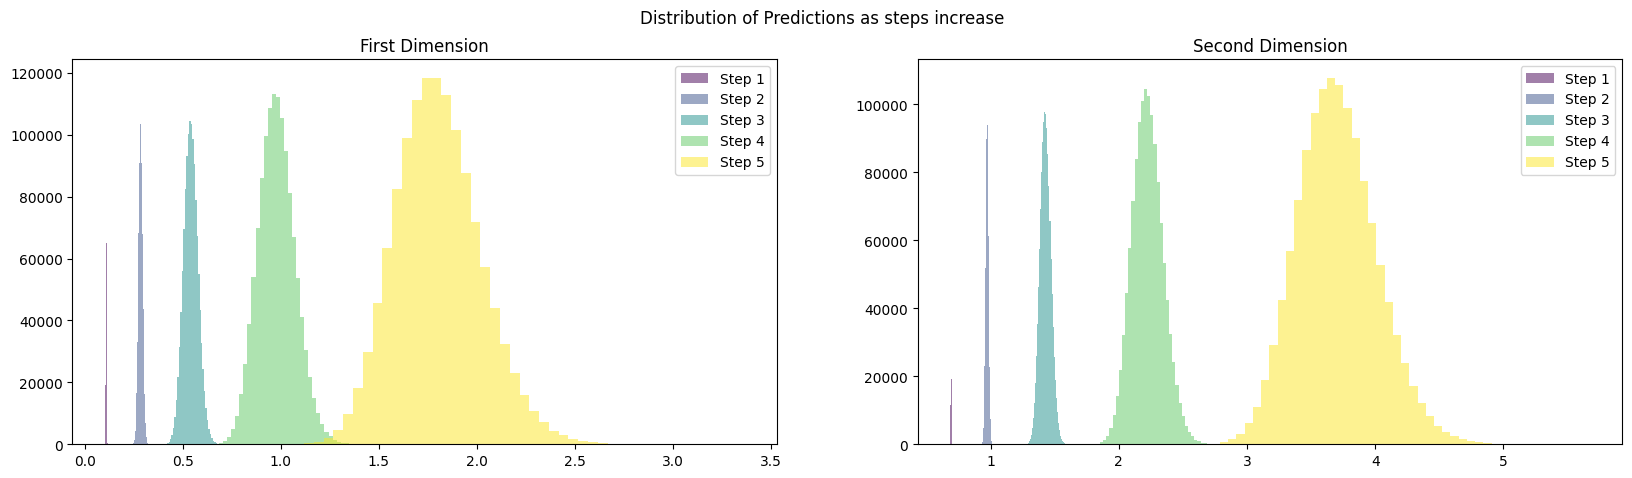

In [16]:
# Build a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot all the data related to separate steps in the first dimensions
for i in range(0, df.iloc[:, 0].max()+1):
    axs[0].hist(df[df.iloc[:, 0] == i].iloc[:, 1], bins=50, alpha=0.5, label=f"Step {i+1}", color=colors[i])

# Plot all the data related to separate steps in the second dimensions
for i in range(0, df.iloc[:, 0].max()+1):
    axs[1].hist(df[df.iloc[:, 0] == i].iloc[:, 2], bins=50, alpha=0.5, label=f"Step {i+1}", color=colors[i])
# Add the legend

axs[0].set_title("First Dimension")
axs[1].set_title("Second Dimension")
axs[0].legend()
axs[1].legend()
plt.suptitle("Distribution of Predictions as steps increase")


This last plot visualizes the added uncertainty due to the evolution in time

## CPU implementation
We decided to use the Joblib library in order to perform single node parallelization since it proved to be the fastest from the last project. In order to do this, it was necessary to rewrite the code using the numpy library instead of jax, which is not compatible with basic parallelization primitives like os.fork(), which are the foundation of the Joblib library. A warning was raised by the library, telling that this could lead to a deadlock during the execution. 
It is more efficient than the multiprocessing library especially when it comes to thread spawning and joining. We used delayed tasks to parallelize the workload of the forecasters. These are evenly spread across the available workers. We did not parallelize the internal operations, since the computation of the time steps in the horizon is intrinsically sequential. Moreover, the linear combination of the weight matrix with the input and bias is not computationally expensive due to the small dimensions of these data structures. 

The anaylsis of the statistics of the weights, biases and predictions is the same as the one performed for the MPI implementation.

### Run the tests
In order to run the simulations of the code, a virtual environment is necessary. We used micromamba to install all the dependencies, which include numpy and joblib. Make sure you also have a virtual environment with all libraries installed. We also set up a batch script called `job_single_node` to run the code on the cluster using Slurm. Of course, you can modify the simulation parameters accordingly to your needs.

## Analysis of the weights

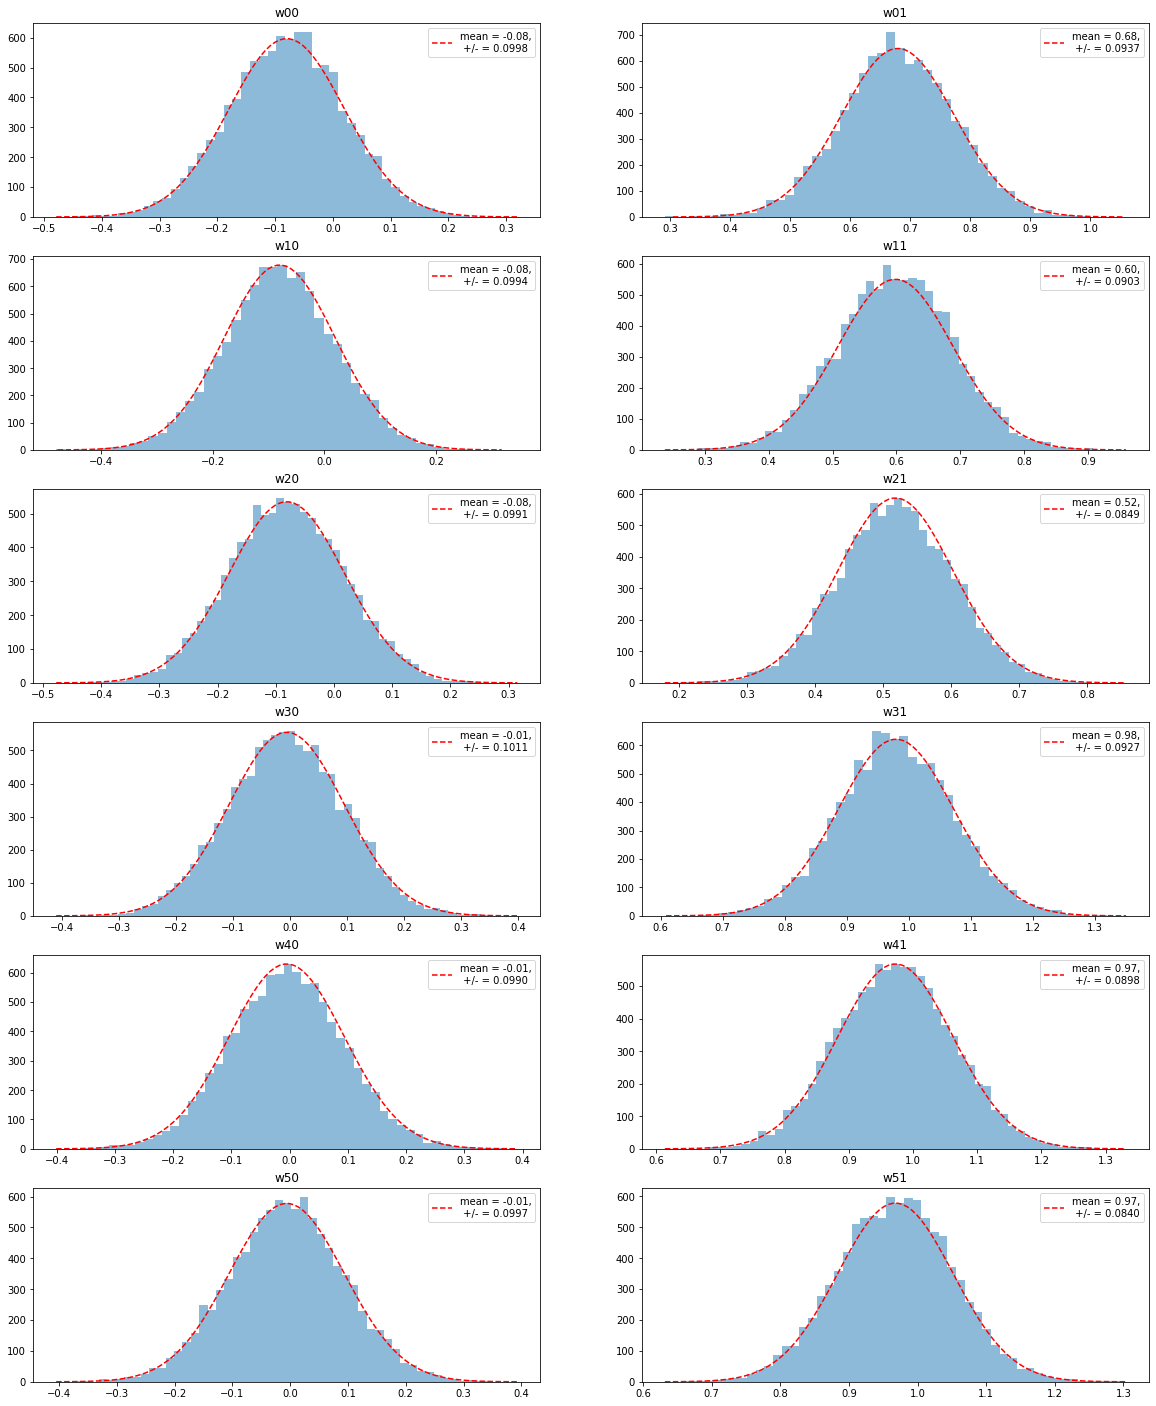

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('data/weights.csv')

# Create a figure with 12 subplots
fig, axs = plt.subplots(6, 2, figsize=(20, 25))  

# On the i-th axis, plot the i-th column of the data
for i, ax in enumerate(axs.flat):
    hist_values, bin_edges, _ = ax.hist(df.iloc[:, i+1], bins=50, alpha=0.5)
    
    # Superimpose a gaussian distribution with the same mean and standard deviation
    mean = df.iloc[:, i+1].mean()
    std = df.iloc[:, i+1].std()
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
    # Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
    
    bin_width = bin_edges[1] - bin_edges[0]
    mean_bin_index = np.digitize(mean, bin_edges) - 1  # Get the bin containing the mean
    mean_bin_height = hist_values[mean_bin_index]

    y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
    
    ax.plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std), )
    ax.legend(loc='upper right')
    ax.set_title(df.columns[i+1])

## Analysis of the biases

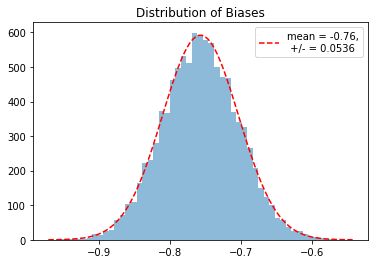

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/biases.csv')
# Create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# Plot the data
hist_values, bin_edges, _ = ax.hist(df.iloc[:, 1], bins=50, alpha=0.5)
ax.set_title("Distribution of Biases")
# Superimpose a gaussian distribution with the same mean and standard deviation
mean = df.iloc[:, 1].mean()
std = df.iloc[:, 1].std()
x = np.linspace(mean - 4*std, mean + 4*std, 100)
y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
# Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
bin_width = bin_edges[1] - bin_edges[0]
mean_bin_index = np.digitize(mean, bin_edges) - 1  # Get the bin containing the mean
mean_bin_height = hist_values[mean_bin_index]
y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
ax.plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std))
ax.legend(loc='upper right')


plt.show()

## Analysis of the predictions

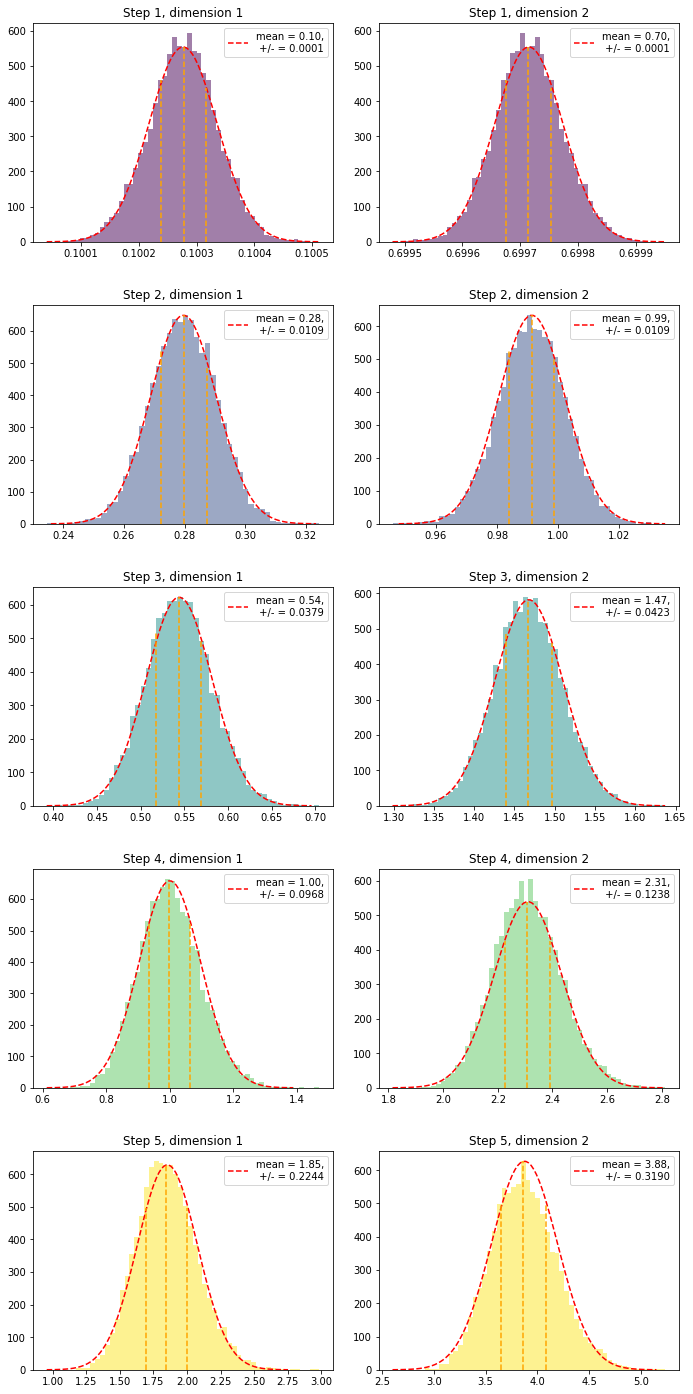

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/aggregated_forecasting_joblib.csv')
# Create a figure with a number of subplots equal to the maximum of the first column
fig, axs = plt.subplots(df.iloc[:, 0].max()+1, 2, figsize=(10, 20))

# define a colormap with a number of colors equal to the maximum in the first column
colors = plt.cm.viridis(np.linspace(0, 1, df.iloc[:, 0].max()+1))

# Plot the data
for i in range(0, df.iloc[:, 0].max()+1):
    for j in range(2):
        hist_values, bin_edges, _ = axs[i, j].hist(df[df.iloc[:, 0] == i].iloc[:, j+1], bins=50, color=colors[i], alpha=0.5)
        axs[i, j].set_title(f"Step {i+1}, dimension {j+1}")

        # Superimpose a gaussian distribution with the same mean and standard deviation
        mean = df[df.iloc[:, 0] == i].iloc[:, j+1].mean()
        std = df[df.iloc[:, 0] == i].iloc[:, j+1].std()
        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
        # Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
        bin_width = bin_edges[1] - bin_edges[0]
        mean_bin_index = np.digitize(mean, bin_edges) - 1
        mean_bin_height = hist_values[mean_bin_index]
        y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
        axs[i, j].plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std))
        axs[i, j].legend(loc='upper right')

        # Add the quantiles to the plot as vertical lines and stop them when they reach the gaussian curve
        quantiles = np.quantile(df[df.iloc[:, 0] == i].iloc[:, j+1], [0.25, 0.50, 0.75])
        for quantile in quantiles:
            axs[i, j].add_line(plt.Line2D([quantile, quantile], [0, y_rescaled[np.searchsorted(x, quantile)]], color='orange', linestyle='--'))

# Add the title to the entire plot
fig.suptitle("")
plt.tight_layout(h_pad=3, pad=2)


## Strong scalability
We measured the strong scalability of the single node implementation by fixing the number of forecasters and increasing the number of threads. The number of forecasters is split into equal parts and each threads is assigned the corresponding amount. Let us plot the speedup as a function of the number of threads, as well as the execution time as a function of the number of threads. We can notice how the time decreases as the number of threads increases, but the speedup is not linear. This is due to the overhead introduced by the parallelization itself, which is not negligible when the number of threads is greater than 32. Thus, we did not experiment with a number of threads greater than 64.

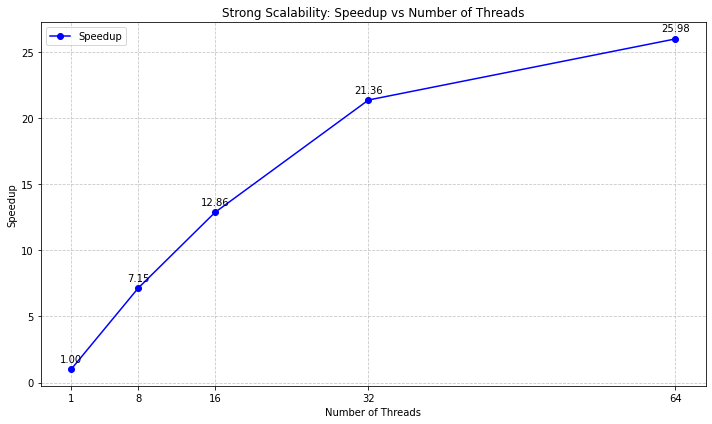

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Filepaths for data
filepaths = {
    1: "times_single_node/time_log_1.txt",
    8: "times_single_node/time_log_8.txt",
    16: "times_single_node/time_log_16.txt",
    32: "times_single_node/time_log_32.txt",
    64: "times_single_node/time_log_64.txt"
}
threads = []
mean_times = []
# Load data and calculate mean execution time for each thread count
for thread_count, filepath in filepaths.items():
    df = pd.read_csv(filepath, sep="\t")
    mean_time = df["Real(s)"].mean()
    threads.append(thread_count)
    mean_times.append(mean_time)

# Calculate speedups relative to the serial time
serial_time = mean_times[0]
speedups = [serial_time / mt for mt in mean_times]

plt.figure(figsize=(10, 6))
plt.plot(threads, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
# Annotate the speedup values
for i, (thread, speedup) in enumerate(zip(threads, speedups)):
    plt.text(thread, speedup + 0.4, f'{speedup:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Number of Threads')
plt.ylabel('Speedup')
plt.title('Strong Scalability: Speedup vs Number of Threads')
plt.xticks(threads)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


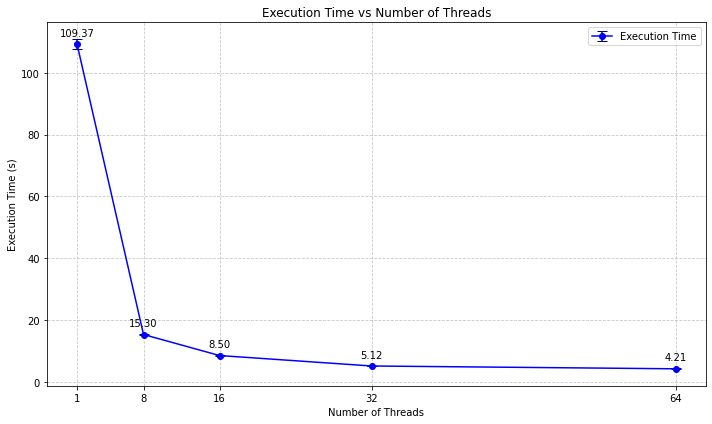

In [3]:
threads = []
mean_times = []
std_devs = []
# Load data, calculate mean and standard deviation for each thread count
for thread_count, filepath in filepaths.items():
    df = pd.read_csv(filepath, sep="\t")
    # Calculate mean and standard deviation
    mean_time = df["Real(s)"].mean()
    std_dev = df["Real(s)"].std()
    threads.append(thread_count)
    mean_times.append(mean_time)
    std_devs.append(std_dev)

plt.figure(figsize=(10, 6))
plt.errorbar(threads, mean_times, yerr=std_devs, fmt='o-', capsize=5, label='Execution Time', color='blue', ecolor='darkblue')

# Annotate the mean execution times
for i, (thread, mean_time) in enumerate(zip(threads, mean_times)):
    plt.text(thread, mean_time + 2, f'{mean_time:.2f}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Number of Threads')
plt.xticks(threads)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()
